In [1]:
import os
import sys
import pandas as pd
import numpy as np
from rdkit import rdBase, Chem, DataStructs
from rdkit.Chem import AllChem, Draw, Descriptors, PandasTools, rdMolDescriptors, QED
from rdkit.Chem.SpacialScore import SPS
import QEPPI as ppi
sys.path.append(os.path.join(os.environ['CONDA_PREFIX'],'share','RDKit','Contrib'))
from SA_Score import sascorer
from NP_Score import npscorer

from QRCI.QRCI import QRCICalculator, get_QRCIproperties
from QRCI.RCI import RCICalculator

PandasTools.RenderImagesInAllDataFrames(True)
from rdkit.Chem.Draw import IPythonConsole

import math
from scipy.stats import pearsonr, spearmanr
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

print(sys.version)
print(rdBase.rdkitVersion)

3.13.2 | packaged by conda-forge | (main, Feb 17 2025, 14:10:22) [GCC 13.3.0]
2025.03.3


In [2]:
# Calculates the SpacialScore descriptor
#https://github.com/frog2000/Spacial-Score
def compute_spacial_score(mol, normalize=True):
    try:
        if mol is None:
            return None
        return SPS(mol, normalize=normalize)
    except Exception as e:
        print(f"Error processing molecule: {e}")
        return None

fscore = npscorer.readNPModel()

reading NP model ...
model in


In [3]:
q = ppi.QEPPI_Calculator()
q.read()

2303


,id,smiles,ROMol
0,2401,CC(C)(C)NCCCNC(=O)c1cccc(C(F)(F)F)c1,
1,2400,CC(C)c1cccc(C(=O)NCCCNC(C)(C)C)c1,
2,775,CCC(CC)CNC(=O)C1CCCN1C(=O)C(NC(=O)C(C)N)C(C)C,
3,2316,CNCC(=O)Nc1nccs1,
4,2315,NCC(=O)Nc1ccc(N)cc1,

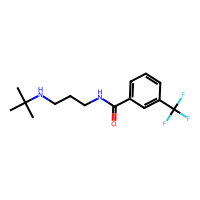
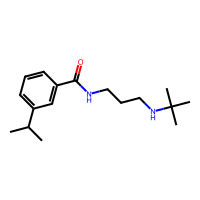
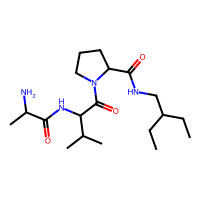
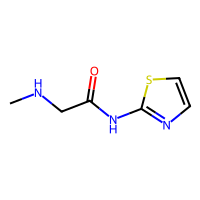
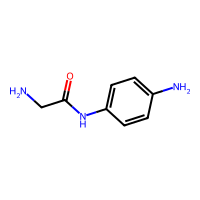

In [4]:
# Load CSV Data
data = pd.read_csv('data/ippidb_comps.csv')
PandasTools.AddMoleculeColumnToFrame(frame=data, smilesCol='smiles')
data = data.dropna(subset=["ROMol"])
data = data.reset_index(drop=True)
print(len(data))
data.head()

(2303, 18)


,id,smiles,ROMol,MolWt,aLogP,TPSA,ROTB,HBA,HBD,Fsp3,nAtom,nHeavyAtom,nRing,QED,QEPPI,SAscore,NPscore,SpacialScore
0,2401,CC(C)(C)NCCCNC(=O)c1cccc(C(F)(F)F)c1,,302.340,3.2134,41.13,5,2,2,0.533333,21,21,1,0.820075,0.335681,2.004249,-1.396997,12.285714
1,2400,CC(C)c1cccc(C(=O)NCCCNC(C)(C)C)c1,,276.424,3.3180,41.13,6,2,2,0.588235,20,20,1,0.782614,0.329392,1.953400,-0.933609,11.700000
2,775,CCC(CC)CNC(=O)C1CCCN1C(=O)C(NC(=O)C(C)N)C(C)C,,368.522,1.0178,104.53,9,4,3,0.842105,26,26,1,0.564930,0.251384,3.271141,-0.423955,19.538462
3,2316,CNCC(=O)Nc1nccs1,,171.225,0.3010,54.02,3,4,2,0.333333,11,11,1,0.687449,0.394292,2.206956,-2.392607,9.545455
4,2315,NCC(=O)Nc1ccc(N)cc1,,165.196,0.1660,81.14,2,3,3,0.125000,12,12,1,0.546083,0.295142,1.695011,-1.227208,9.416667

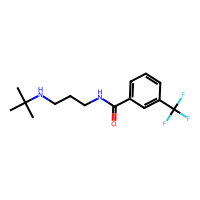
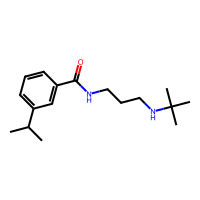
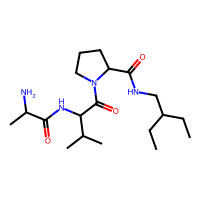
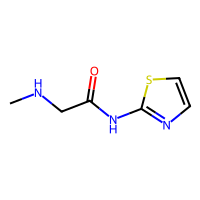
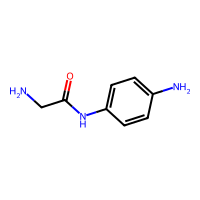

In [5]:
#Descriptor Calculation
data['MolWt'] = data.ROMol.map(Descriptors.MolWt)
data['aLogP'] = data.ROMol.map(Descriptors.MolLogP)
data['TPSA'] = data.ROMol.map(Descriptors.TPSA)
data['ROTB'] = data.ROMol.map(Descriptors.NumRotatableBonds)
data['HBA'] = data.ROMol.map(Descriptors.NumHAcceptors)
data['HBD'] = data.ROMol.map(Descriptors.NumHDonors)
data['Fsp3'] = data.ROMol.map(Descriptors.FractionCSP3)
data['nAtom'] = data.ROMol.map(lambda x: x.GetNumAtoms())
data['nHeavyAtom'] = data.ROMol.map(Descriptors.HeavyAtomCount)
data['nRing'] = data.ROMol.map(AllChem.CalcNumRings)
data['QED'] = data.ROMol.map(QED.qed)
data['QEPPI'] = data.ROMol.map(lambda mol: q.qeppi(mol, method="mo"))
data['SAscore'] = data.ROMol.map(sascorer.calculateScore)
data['NPscore'] = data['ROMol'].apply(lambda m: npscorer.scoreMol(m, fscore) if m else None)
data["SpacialScore"] = data["ROMol"].apply(lambda x: compute_spacial_score(x))
print(data.shape)
data.head()

(2303, 20)


,id,smiles,ROMol,MolWt,aLogP,TPSA,ROTB,HBA,HBD,Fsp3,nAtom,nHeavyAtom,nRing,QED,QEPPI,SAscore,NPscore,SpacialScore,RCI,QRCI
0,2401,CC(C)(C)NCCCNC(=O)c1cccc(C(F)(F)F)c1,,302.340,3.2134,41.13,5,2,2,0.533333,21,21,1,0.820075,0.335681,2.004249,-1.396997,12.285714,1.0,2.161131
1,2400,CC(C)c1cccc(C(=O)NCCCNC(C)(C)C)c1,,276.424,3.3180,41.13,6,2,2,0.588235,20,20,1,0.782614,0.329392,1.953400,-0.933609,11.700000,1.0,2.148933
2,775,CCC(CC)CNC(=O)C1CCCN1C(=O)C(NC(=O)C(C)N)C(C)C,,368.522,1.0178,104.53,9,4,3,0.842105,26,26,1,0.564930,0.251384,3.271141,-0.423955,19.538462,1.0,2.560238
3,2316,CNCC(=O)Nc1nccs1,,171.225,0.3010,54.02,3,4,2,0.333333,11,11,1,0.687449,0.394292,2.206956,-2.392607,9.545455,1.0,2.145188
4,2315,NCC(=O)Nc1ccc(N)cc1,,165.196,0.1660,81.14,2,3,3,0.125000,12,12,1,0.546083,0.295142,1.695011,-1.227208,9.416667,1.0,2.021227

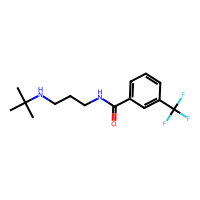
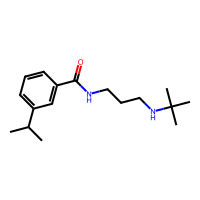
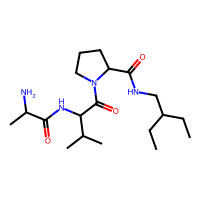
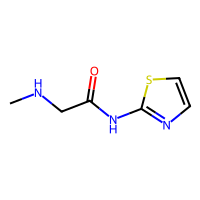
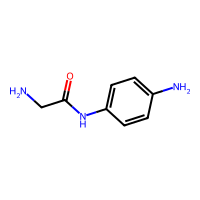

In [6]:
# Add RCI & QRCI Column
rci_calculator = RCICalculator()
qrci_calculator = QRCICalculator(weights="mean")

data['RCI'] = data['ROMol'].apply(lambda mol: rci_calculator(mol))
data['QRCI'] = data['ROMol'].apply(lambda mol: qrci_calculator(mol))

print(data.shape)
data.head()

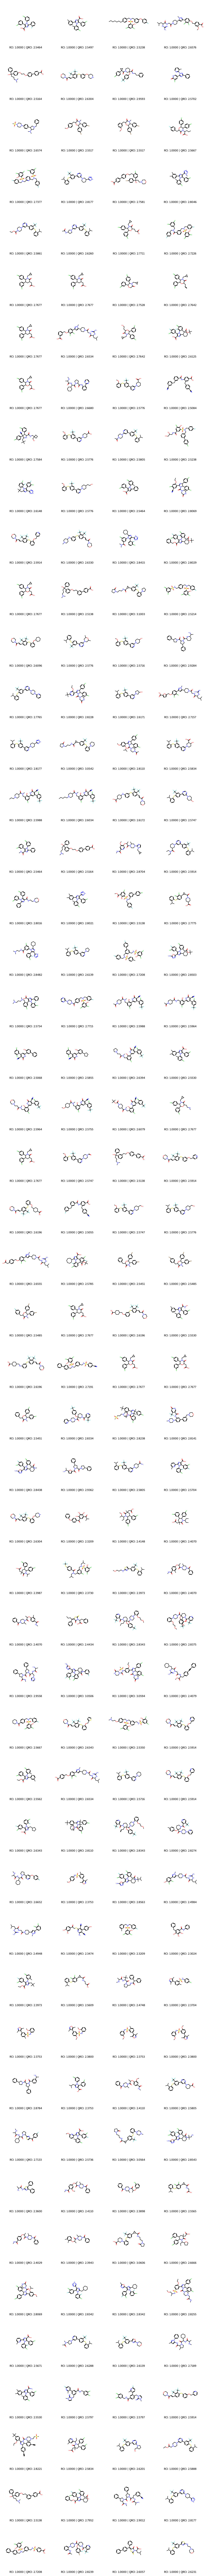

In [7]:
data = data.sort_values(by="RCI")
Draw.MolsToGridImage(data.ROMol[:200], 
                     legends=[f"RCI: {r:.4f} | QRCI: {q:.4f}" for r, q in zip(data['RCI'][:200], data['QRCI'][:200])], 
                     molsPerRow=4, 
                     subImgSize=(300, 300), 
                     maxMols=200)

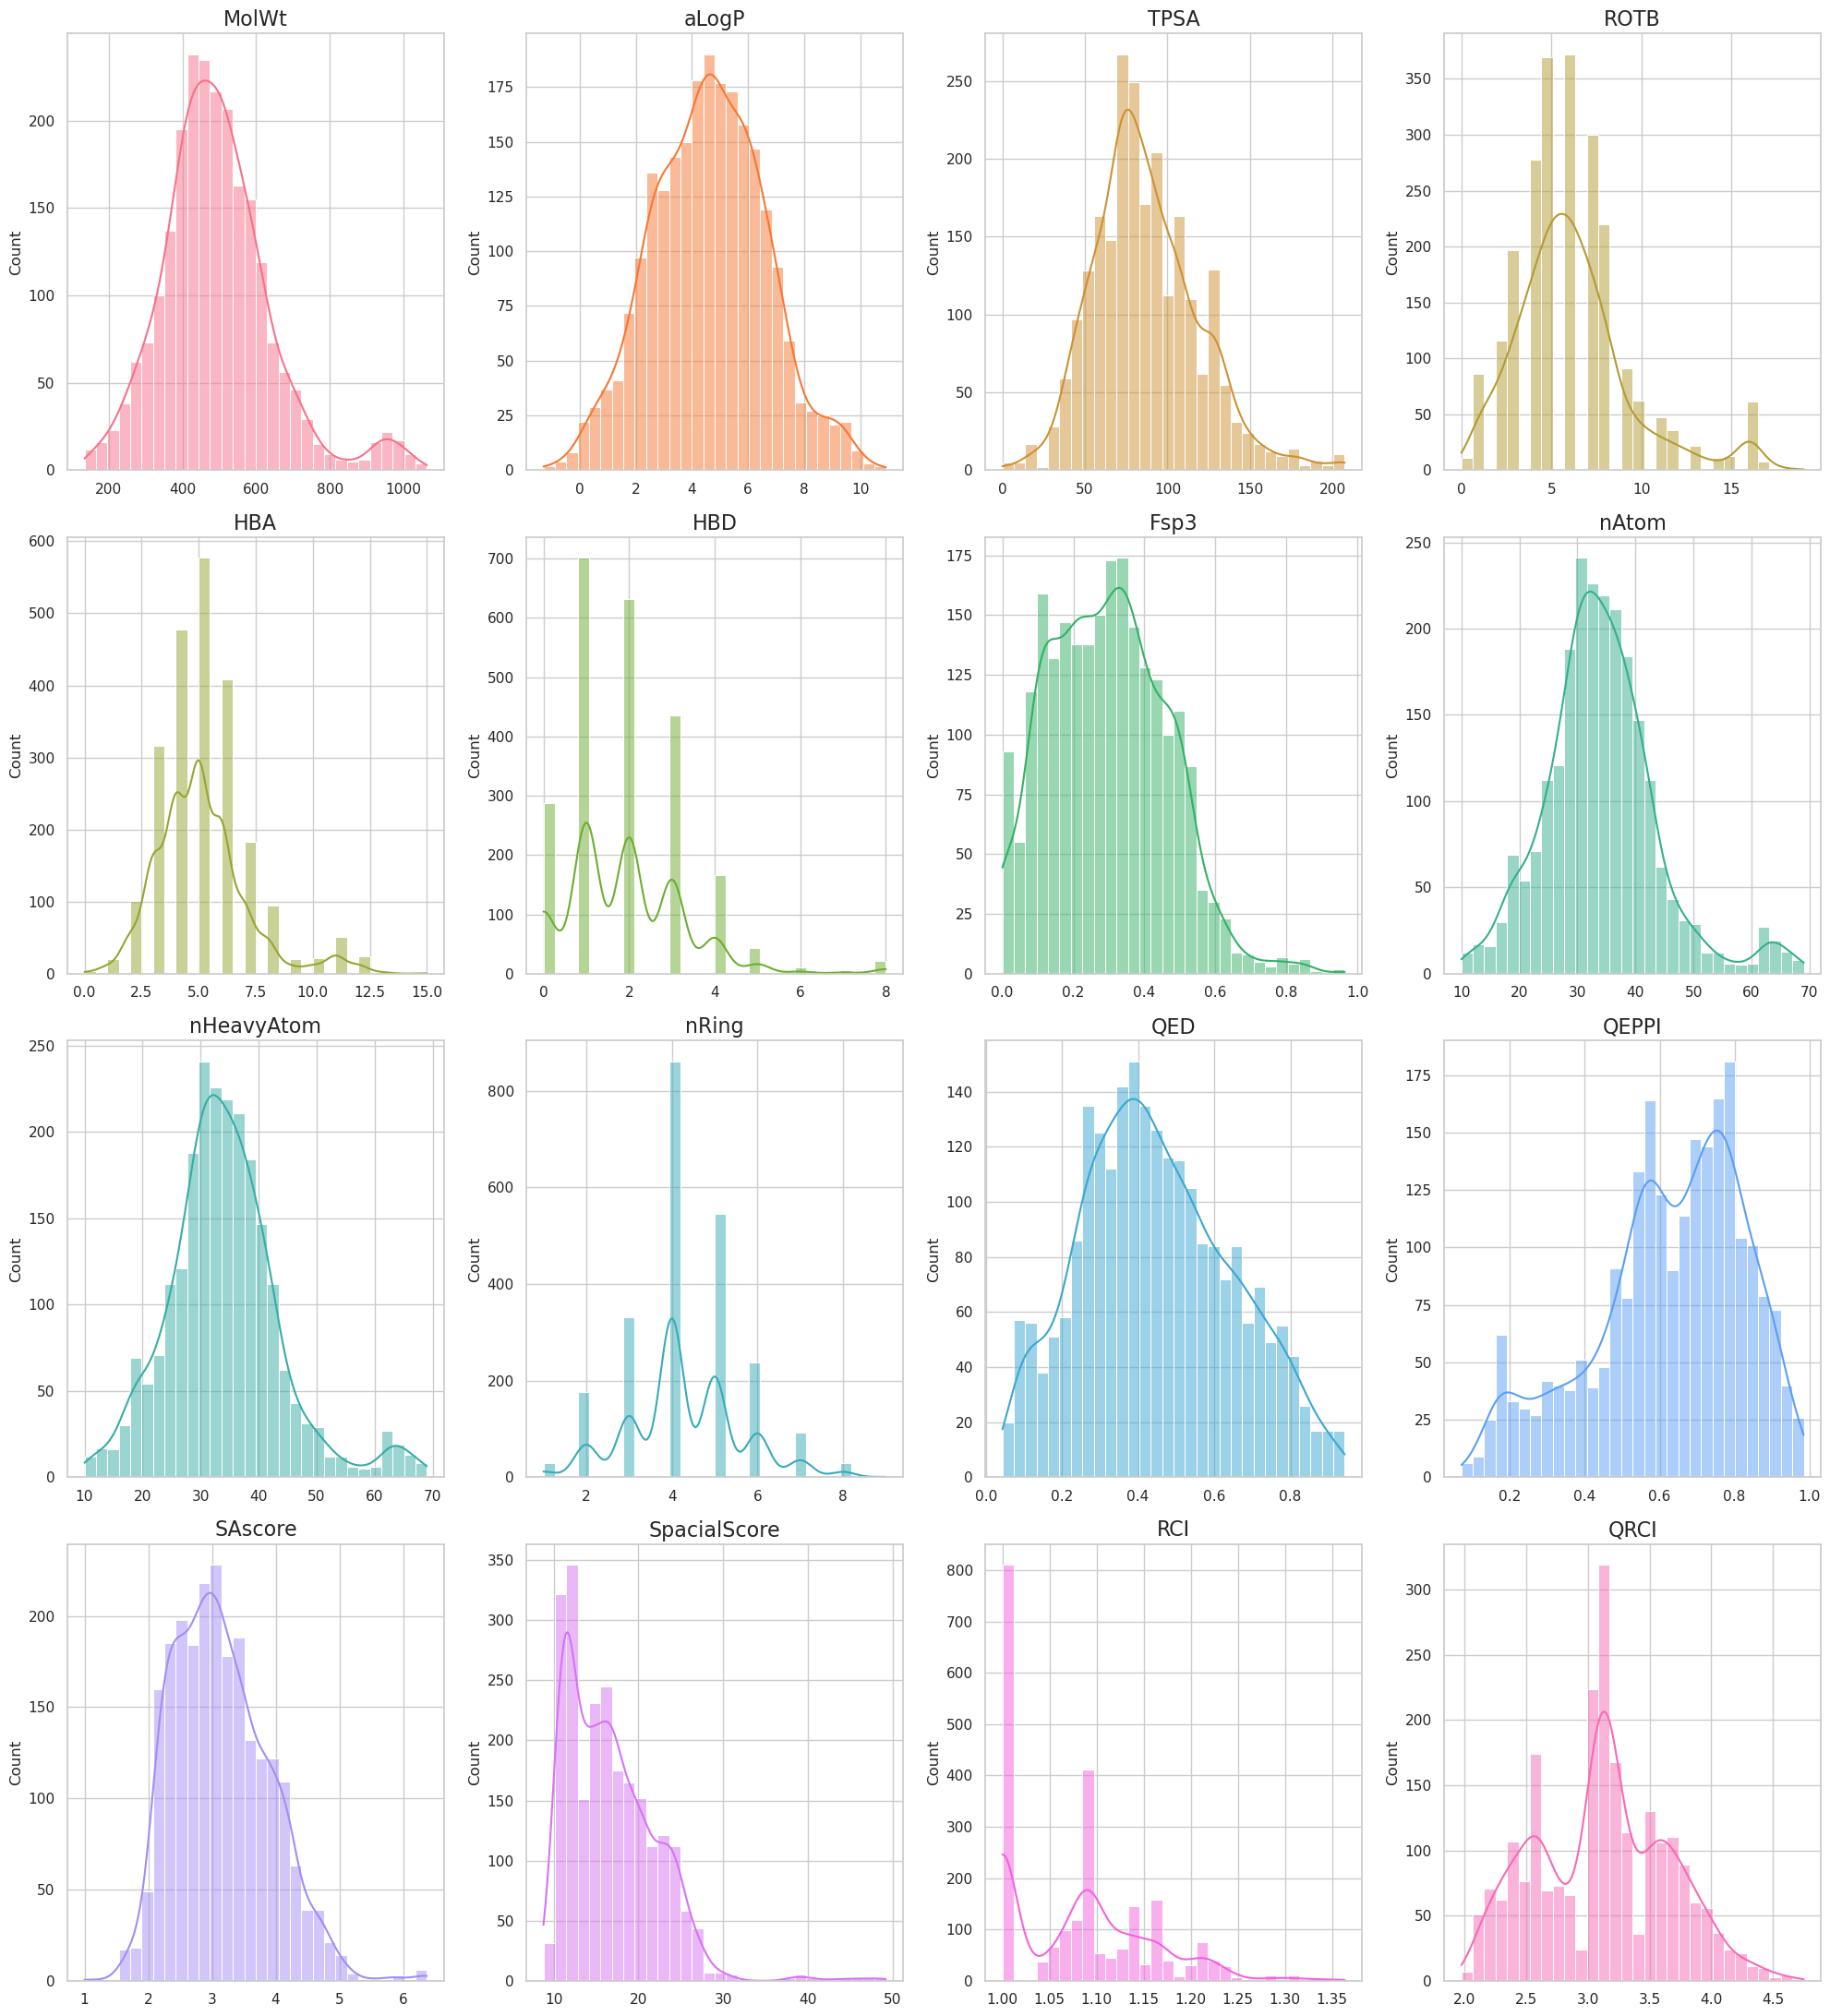

In [8]:
sns.set(style="whitegrid")
plt.figure(figsize=(20, 22))

props = [
    'MolWt', 'aLogP', 'TPSA', 'ROTB', 'HBA', 'HBD',
    'Fsp3', 'nAtom', 'nHeavyAtom', 'nRing',
    'QED', 'QEPPI', 'SAscore', 'SpacialScore', 'RCI', 'QRCI'
]

colors = sns.color_palette("husl", len(props))
ncols = 4
nrows = (len(props) + ncols - 1) // ncols

for i, (prop, color) in enumerate(zip(props, colors)):
    plt.subplot(nrows, ncols, i + 1)
    sns.histplot(data[prop].dropna(), bins=30, kde=True, color=color)
    plt.title(prop, fontsize=16)
    plt.xlabel("")
    plt.ylabel("Count")

plt.tight_layout()
plt.show()

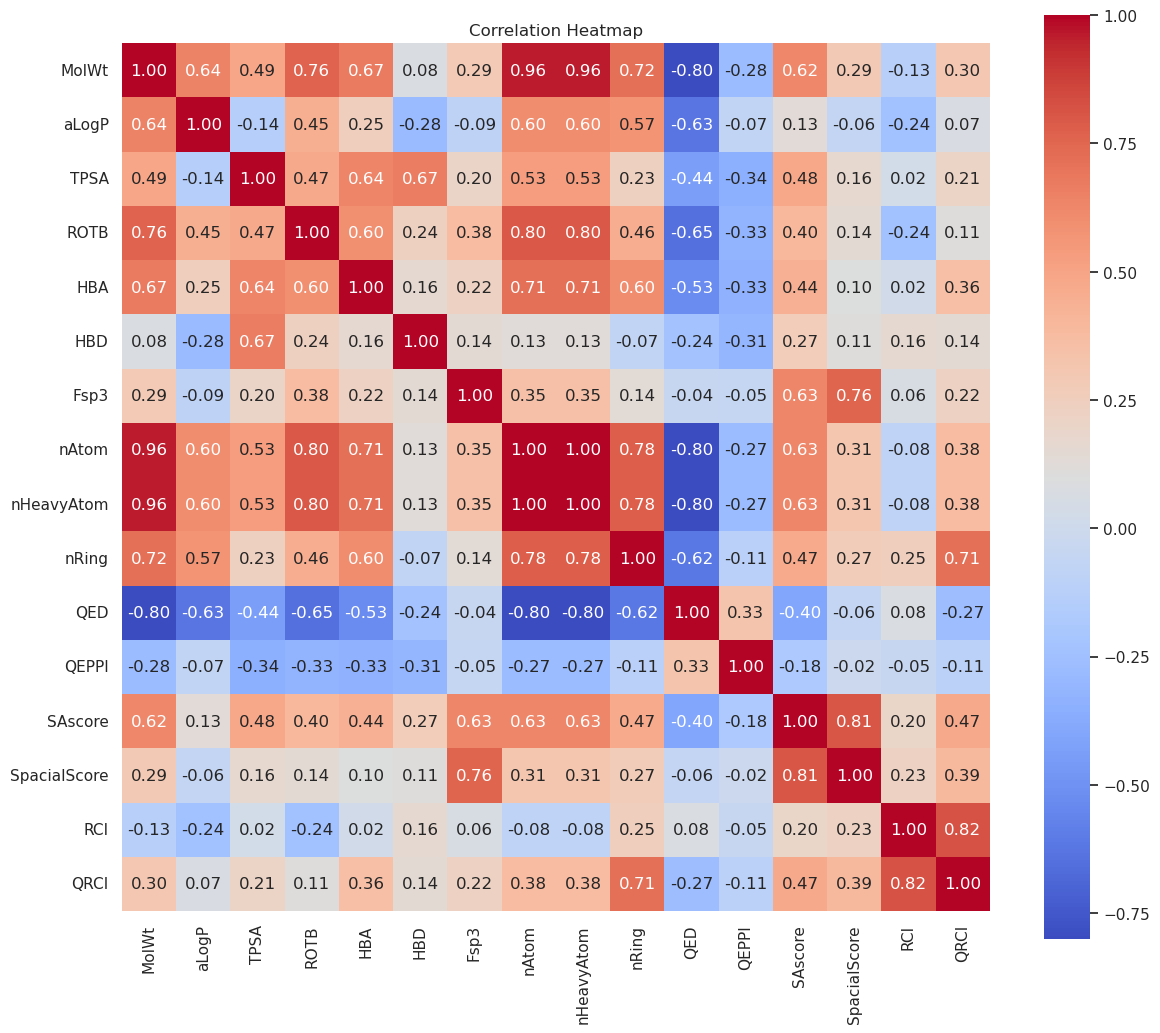

In [9]:
corr_data = data[props].dropna()
corr = corr_data.corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap")
plt.show()